In [3]:
!pip install ijson
!pip install tensorflow-addons

     |████████████████████████████████| 126 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [4]:
import ijson
import json
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import random
import math
from contextlib import contextmanager
import codecs
import matplotlib
import matplotlib.pyplot as plt
import numpy.ma as ma
from tensorflow import keras as K
import importlib
from tqdm import tqdm, trange
import os
import sys
import math
import time

In [5]:
!if cd Decoder-SketchRNN; then git pull; else git clone https://github.com/salbrandi/Decoder-SketchRNN.git; fi

sys.path.append('/content/Decoder-SketchRNN')

from sketchrnn import models, dataset, utils


from google.colab import drive
drive.mount('/content/drive')

/bin/bash: line 0: cd: Decoder-SketchRNN: No such file or directory
Cloning into 'Decoder-SketchRNN'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 140 (delta 31), reused 48 (delta 18), pack-reused 77
Receiving objects: 100% (140/140), 14.29 MiB | 28.53 MiB/s, done.
Resolving deltas: 100% (64/64), done.
Mounted at /content/drive


In [6]:
# INPUTS PREPROCESSING
'''
Input: Phrase from region_descriptions.json (individual words)
Output: Senetence Embedding 

Part 1:
- tuple of image_id and phrase from region_descriptions.json

Part 2:
- Get corresponding bounding boxes for objects in that region/phrase

Part 3:
- Preprocess the phrases into tokens

Part 4:
- Using GLOVE embeddings to convert tokens to embeddings
'''

'\nInput: Phrase from region_descriptions.json (individual words)\nOutput: Senetence Embedding \n\nPart 1:\n- tuple of image_id and phrase from region_descriptions.json\n\nPart 2:\n- Get corresponding bounding boxes for objects in that region/phrase\n\nPart 3:\n- Preprocess the phrases into tokens\n\nPart 4:\n- Using GLOVE embeddings to convert tokens to embeddings\n'

In [7]:
f = open('/content/drive/MyDrive/DL Project/image_data.json')
image_data = json.load(f)


In [8]:
wh_dict = {}
for i in range(len(image_data)):
  wh_dict[image_data[i]['image_id']] = [image_data[i]['width'], image_data[i]['height']]

In [9]:
# Part 1: Optimized (RAM issues)
label_map = []
enc_inputs = []
name_syn = {}

with open("/content/drive/MyDrive/DL Project/region_graphs.json", "r") as f:
    count = 0
    #objt = []
    synsets = []
    for record in ijson.items(f, "item"):
        if count==5000:
          break
        image_id = record["image_id"]
        width = wh_dict[image_id][0]
        height = wh_dict[image_id][1]
        for j in range(7): #len(record["regions"])):
          phrase = record["regions"][j]["phrase"]
          region_id = record["regions"][j]["region_id"]
          obj = {}
          name2syn = {}
          for o in range(len(record["regions"][j]["objects"])):
            if record["regions"][j]["objects"][o]["synsets"]:
              name2syn[record["regions"][j]["objects"][o]["name"]] = record["regions"][j]["objects"][o]["synsets"][0]
              name_syn[record["regions"][j]["objects"][o]["name"]] = record["regions"][j]["objects"][o]["synsets"][0]
            else:
              name2syn[record["regions"][j]["objects"][o]["name"]] = record["regions"][j]["objects"][o]["name"]
              name_syn[record["regions"][j]["objects"][o]["name"]] = record["regions"][j]["objects"][o]["name"]


            x_min = record["regions"][j]["objects"][o]["x"]/width
            y_min = record["regions"][j]["objects"][o]["y"]/height
            x_max = (x_min + record["regions"][j]["objects"][o]["w"])/width
            y_max = (y_min + record["regions"][j]["objects"][o]["h"])/height
            #obj[name2syn[record["regions"][j]["objects"][o]["name"]]] = [x_min,y_min,x_max,y_max]
            obj[name2syn[record["regions"][j]["objects"][o]["name"]]] = [y_min,x_min,y_max,x_max]
            #objt.append(record["regions"][j]["objects"][o]['object_id'])
            synsets.append(name2syn[record["regions"][j]["objects"][o]["name"]])


          input = (image_id, region_id, phrase, obj, name2syn)
          label_map.append(input)
          enc_inputs.append(phrase)
          #dec_inputs.append(obj.values())
          
        count+=1

vocab = list(set(synsets))
vocab.append('no object')


print(label_map)
#print(enc_inputs)
#print(dec_inputs)
#print(name_syn)
#print(vocab)

VOCAB_SIZE = len(vocab)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
# Part 3: Preprocess the phrases into tokens
def word_ind(sentences,vocab, name2syn):
  class_map = {}
  map = {}
  ulta_map = {}
  ulta_class = {}
  idx = 1
  class_id = 1
  for i in range(len(sentences)):
    words = sentences[i].split(" ")
    for j in words:
      if j not in map:
        map[j] = idx
        ulta_map[idx] = j
        idx+=1
      if j in name2syn and name2syn[j] in vocab:
        if name2syn[j] not in class_map:
          class_map[name2syn[j]] = class_id
          ulta_class[class_id] = name2syn[j]
          class_id+=1
      else:
          class_map[j] = 0

  return map, ulta_map, class_map, ulta_class


word_map, idx_map, class_map, ulta_class = word_ind(enc_inputs,vocab, name_syn)


enc_inputs = [sub.split(" ") for sub in enc_inputs]

for i in range(len(enc_inputs)):
  for j in range(len(enc_inputs[i])):
    enc_inputs[i][j] = word_map[enc_inputs[i][j]]



In [11]:
idx_map[0] = 'UNK'
ulta_class[0] = 'no object'
class_map['UNK'] = 0

In [12]:
#Padding the input sentences that are in integer form 
enc_inputs = tf.keras.preprocessing.sequence.pad_sequences(enc_inputs, padding="post")
class_labels = np.zeros((35000,enc_inputs.shape[1]))

for i in range(len(enc_inputs)):
  for j in range(len(enc_inputs[i])):
    if idx_map[enc_inputs[i][j]] in name_syn:
      class_labels[i][j] = class_map[name_syn[idx_map[enc_inputs[i][j]]]]
    else:
      class_labels[i][j] = class_map[idx_map[enc_inputs[i][j]]]

#print(class_labels[:100])
#print(len(class_labels[0]))


In [13]:
labels = np.zeros((len(enc_inputs),enc_inputs.shape[1], 4))#*-1

for i in range(len(enc_inputs)):
  for j in range(enc_inputs.shape[1]):
    name = idx_map[enc_inputs[i][j]]
    
    if name not in label_map[i][4]:
      continue
    
    class_label = label_map[i][4][name]
    labels[i][j] = label_map[i][3][class_label]

print(labels[0])

[[0.         0.         0.         0.        ]
 [0.15166667 0.52625    0.56525278 0.09940781]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


In [14]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

embedd = load_glove_model('/content/drive/MyDrive/DL Project/glove.6B/glove.6B.200d.txt')

Loading Glove Model
400000 words loaded!


In [15]:
def get_w2v(sentence, model, idx_map):
    """
    :param sentence: inputs a single sentences whose word embedding is to be extracted.
    :param model: inputs glove model.
    :return: returns numpy array containing word embedding of all words in input sentence.
    """
    return np.array([model.get(idx_map[val], np.zeros(200)) for val in sentence])


embed_sentence = np.zeros((len(enc_inputs),len(enc_inputs[0]),200))

for i in range(len(enc_inputs)):
  embed_sentence[i] = get_w2v(enc_inputs[i], embedd, idx_map)


In [16]:

class Singleton(type):
    """Metaclass for Singleton objects

    From Python Cookbook, 3rd edition, by David Beazley and Brian K. Jones (O’Reilly).
    Copyright 2013 David Beazley and Brian Jones, 978-1-449-34037-7
    """
    def __init__(self, *args, **kwargs):
        self.__instance = None
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        if self.__instance is None:
            self.__instance = super().__call__(*args, **kwargs)
            return self.__instance
        else:
            return self.__instance

class ReservoirSample1:
    """Randomly sample single item from data stream of indeterminate length
    
    Implementation after Algorithm L:
    Li, Kim-Hung. "Reservoir-sampling algorithms of time complexity O (n (1+ log (N/n)))."
    ACM Transactions on Mathematical Software (TOMS) 20, no. 4 (1994): 481-493.
    """
    
    def _update_s(self):
        """Update s based on w"""
        self.s = int(math.log(random.random()) / math.log(1.0 - self.w))
        
    def __init__(self):
        self.w = random.random()
        self._update_s()
        self.data = None
        self.stepno = 1
        self.target_step = 2 + self.s
        self.last_data_step = None # Just for debug
        
    def step(self, data):
        """Single time-step of data stream"""
        if self.stepno == 1:
            self.data = data
        elif self.stepno == self.target_step:
            self.data = data
            self.w = self.w * random.random()
            self._update_s()
            self.target_step = self.stepno + 1 + self.s
            self.last_data_step = self.stepno # Debug
        self.stepno += 1
            

class AttentionVis(metaclass=Singleton):
    """Global mechanism for saving and displaying attention-matrix visualization
    
    Store and later retrieve (and display) a single, randomly chosen attention matrix and
    its corresponding English sentence from the decoder block while the "test"
    operation is running.
    
    This class depends on the call structure (and argument order) of many stencil
    functions being preserved. It also depends on several function decorators
    and a "with" statement inside the transformer code to succesfully store and
    retrieve its data.
    """ 
    def __init__(self):
        self.enabled = False # Whether visualization even runs (decided by student)
        self.in_test = False # Shims are in the test function (as opposed to train)
        self.in_decoder = False # Shims are in the decoder (as opposed to encoder)
        self.rsample1 = ReservoirSample1() # Random sampling engine
        
        # randomly selected data within current batch
        # shared between the different shims
        self.cur_batch_data = { 
            "sent_ids": None,
            "att_mat": None,
            "index": None,
        }
        
        # Final data for showing heat map
        self.atten_matrix = None # The matrix itself (14x14)
        self.sentence = None # List of the words of the sentence
        self.rev_en_vocab = None # Reverse English vocabulary (id->word)

    def _setup_atten_heatmap(self, ax):
        """
        Create a heatmap from a numpy array and two lists of labels.
    
        This function derived from:
        https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

        ax - a "matplotlib.axes.Axes" instance to which the heatmap is plotted
        """
        
        data = self.atten_matrix
        row_labels = col_labels = self.sentence

        cbarlabel="Attention Score"
        cbar_kw={}

        # Plot the heatmap
        im = ax.imshow(data, cmap="Blues", vmin=0.0, vmax=1.0)

        # Create colorbar
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

        # We want to show all ticks...
        ax.set_xticks(np.arange(data.shape[1]))
        ax.set_yticks(np.arange(data.shape[0]))
        # ... and label them with the respective list entries.
        ax.set_xticklabels(col_labels)
        ax.set_yticklabels(row_labels)

        # Let the horizontal axes labeling appear on top.
        ax.tick_params(top=True, bottom=False,
                       labeltop=True, labelbottom=False)

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
                 rotation_mode="anchor")

        # Turn spines off and create white grid.
        for edge, spine in ax.spines.items():
            spine.set_visible(False)

        ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
        ax.tick_params(which="minor", bottom=False, left=False)

    def setup_visualization(self, enable=False):
        """Allow the student to turn visualization on or off"""
        self.enabled = enable

    def show_atten_heatmap(self):
        """Display heatmap from saved data after test run complete"""
        if self.enabled and self.atten_matrix is not None:
            fig, ax = plt.subplots()
            self._setup_atten_heatmap(ax)
            fig.tight_layout()
            plt.show()
        
    def test_func(self, func):
        """Shim for student's top-level test function
        
        Set a flag that signals to the other shims that we're inside the test function.
        Turn off graph execution if visualization is enabled.
        """
        def wrapper(*args, **kwargs):
            if self.enabled:
                self.in_test = True
                # The attention visualization is not compatible with tf.function. Oops.
                # Turn it off (but only if student requested visualizations)
                # The good news is: this won't affect "train"
                tf.config.run_functions_eagerly(True)
            ret = func(*args, **kwargs)
            # Save the data
            if self.enabled and self.rsample1.data:
                self.atten_matrix = self.rsample1.data["att_mat"]
                self.sentence = [self.rev_en_vocab[word] for word in self.rsample1.data["sent_ids"]]
                tf.config.run_functions_eagerly(False)
                self.in_test = False
                print("Collecting att matrix from batch", self.rsample1.last_data_step)
            return ret
        return wrapper
    
    def call_func(self, func):
        """Shim for student's main transformer call function
        
        If inside the test function, pick a random decoder sentence and remember its index
        """
        def wrapper(*args, **kwargs):
            if self.enabled and self.in_test:
                decoder_input = args[2]
                ridx = random.randint(0, len(decoder_input)-1)
                self.cur_batch_data["index"] = ridx
                self.cur_batch_data["sent_ids"] = list(decoder_input[ridx])
            ret = func(*args, **kwargs)
            if self.enabled and self.in_test:
                # Attention matrix should be collected at this point
                self.rsample1.step(self.cur_batch_data)
            return ret
        return wrapper
        
    def att_mat_func(self, func):
        """Shim for student's self-attention function
        
        If in the test function, and this is a decoder, store the attention matrix
        that corresponds with the saved index from the batch.
        """
        def wrapper(*args, **kwargs):
            ret = func(*args, **kwargs)
            if self.enabled and self.in_test and self.in_decoder:
                # The return value of this function contains the to-be-visualized
                # attention matrix
                self.cur_batch_data["att_mat"] = ret[self.cur_batch_data["index"]].numpy()
            return ret
        return wrapper
        
    def get_data_func(self, func):
        """Shim for student's get-data function
        
        Collect the English vocab and reverse it
        """
        def wrapper(*args, **kwargs):
            ret = func(*args, **kwargs)
            if self.enabled:
                en_vocab = ret[4]
                self.rev_en_vocab = {v:k for k,v in en_vocab.items()}
            return ret
        return wrapper
        
    @contextmanager
    def trans_block(self, is_decoder):
        """Shim for recording which transformer block we're in (encoder/decoder)"""
        try:
            self.in_decoder = is_decoder
            yield
        finally:
            self.in_decoder = False



In [17]:
class FixedEmbedding(tf.keras.layers.Layer):
    def __init__(self, embed_shape, **kwargs):
        super().__init__(**kwargs)
        self.embed_shape = embed_shape

    def build(self, input_shape):
        self.w = self.add_weight(name='kernel', shape=self.embed_shape,
                                 initializer=tf.keras.initializers.GlorotUniform(), trainable=True)

    def call(self, x=None):
        return self.w

In [18]:
av = AttentionVis()

def Attention_Matrix(K, Q, use_mask=False):
  """
  This functions runs a single attention head.
  :param K: is [batch_size x window_size_keys x embedding_size]
  :param Q: is [batch_size x window_size_queries x embedding_size]
  :return: attention matrix
  """

  window_size_queries = Q.get_shape()[1] # window size of queries
  window_size_keys = K.get_shape()[1] # window size of keys
  mask = tf.convert_to_tensor(value=np.transpose(np.tril(np.ones((window_size_queries,window_size_keys))*np.NINF,-1),(1,0)),dtype=tf.float32)
  atten_mask = tf.tile(tf.reshape(mask,[-1,window_size_queries,window_size_keys]),[tf.shape(input=K)[0],1,1])

  # TODO:
  # 1) compute attention weights using queries and key matrices (if use_mask==True, then make sure to add the attention mask before softmax)
  # 2) return the attention matrix


  # Check lecture slides for how to compute self-attention.
   # You can use tf.transpose or tf.tensordot to perform the matrix multiplication for 3D matrices
  # Remember:
  # - Q is [batch_size x window_size_queries x embedding_size]
  # - K is [batch_size x window_size_keys x embedding_size]
  # - Mask is [batch_size x window_size_queries x window_size_keys]


  # Here, queries are matmuled with the transpose of keys to produce for every query vector, weights per key vector.
  # This can be thought of as: for every query word, how much should I pay attention to the other words in this window?
  # Those weights are then used to create linear combinations of the corresponding values for each query.
  # Those queries will become the new embeddings.
  if use_mask == False:
    attn_mat = tf.nn.softmax(tf.linalg.matmul(Q,K, transpose_b = True)/np.sqrt(K.get_shape()[2]))

  else:
    attn_mat = tf.nn.softmax(tf.linalg.matmul(Q,K, transpose_b = True)/np.sqrt(K.get_shape()[2]) + atten_mask)

  return attn_mat


class Atten_Head(tf.keras.layers.Layer):
  def __init__(self, input_size, output_size, use_mask):
    super(Atten_Head, self).__init__()

    self.use_mask = use_mask

    # TODO:
    # Initialize the weight matrices for K, V, and Q.
    # They should be able to multiply an input_size vector to produce an output_size vector
    # Hint: use self.add_weight(...)
    self.K_weight = self.add_weight("k_vec",shape=(input_size, output_size),initializer='random_normal',trainable=True)
    self.V_weight = self.add_weight("v_vec",shape=(input_size, output_size),initializer='random_normal',trainable=True)
    self.Q_weight = self.add_weight("q_vec",shape=(input_size, output_size),initializer='random_normal',trainable=True)

  @tf.function
  def call(self, inputs_for_keys, inputs_for_values, inputs_for_queries):

    """
    This functions runs a single attention head.
    :param inputs_for_keys: tensor of [batch_size x [ENG/FRN]_WINDOW_SIZE x input_size ]
    :param inputs_for_values: tensor of [batch_size x [ENG/FRN]_WINDOW_SIZE x input_size ]
    :param inputs_for_queries: tensor of [batch_size x [ENG/FRN]_WINDOW_SIZE x input_size ]
    :return: tensor of [BATCH_SIZE x (ENG/FRN)_WINDOW_SIZE x output_size ]
    """

    # TODO:
    # - Apply 3 matrices to turn inputs into keys, values, and queries. You will need to use tf.tensordot for this.
    # - Call Attention_Matrix with the keys and queries, and with self.use_mask.
    # - Apply the attention matrix to the values

    K = tf.matmul(inputs_for_keys,self.K_weight)
    V = tf.matmul(inputs_for_values,self.V_weight)
    Q = tf.matmul(inputs_for_queries,self.Q_weight)

    attn_mat = Attention_Matrix(K, Q, use_mask=self.use_mask)
    output_mat = tf.matmul(attn_mat, V)

    return output_mat



class Multi_Headed(tf.keras.layers.Layer):
  def __init__(self, emb_sz, use_mask):
    super(Multi_Headed, self).__init__()

    # TODO:
    # Initialize heads
    self.emb_sz = emb_sz
    self.batch = int(emb_sz/3)
    self.head1 = Atten_Head(emb_sz, self.batch , use_mask)
    self.head2 = Atten_Head(emb_sz, self.batch, use_mask)
    self.head3 = Atten_Head(emb_sz, self.batch, use_mask)
    self.use_mask = use_mask
    self.dense = tf.keras.layers.Dense(emb_sz)

  @tf.function
  def call(self, inputs_for_keys, inputs_for_values, inputs_for_queries):
    """
    FOR CS2470 STUDENTS:
    This functions runs a multiheaded attention layer.
    Requirements:
      - Splits data for 3 different heads into size embed_sz/3
      - Create three different attention heads
      - Each attention head should have input size embed_size and output embed_size/3
      - Concatenate the outputs of these heads together
      - Apply a linear layer
    :param inputs_for_keys: tensor of [batch_size x [ENG/FRN]_WINDOW_SIZE x input_size ]
    :param inputs_for_values: tensor of [batch_size x [ENG/FRN]_WINDOW_SIZE x input_size ]
    :param inputs_for_queries: tensor of [batch_size x [ENG/FRN]_WINDOW_SIZE x input_size ]
    :return: tensor of [BATCH_SIZE x (ENG/FRN)_WINDOW_SIZE x output_size ]
    """
  
    output1 = self.head1.call(inputs_for_keys, inputs_for_values, inputs_for_queries)
    output2 = self.head2.call(inputs_for_keys, inputs_for_values, inputs_for_queries)
    output3 = self.head3.call(inputs_for_keys, inputs_for_values, inputs_for_queries)


    #output = tf.transpose(tf.stack([output1,output2,output3]), perm = [1,2,0,3])
    #output = tf.reshape(output, (inputs_for_values.get_shape()[0], -1, self.emb_sz))
    output = tf.concat([output1,output2,output3],axis=2)
    
    output = self.dense(output)

    return output


class Feed_Forwards(tf.keras.layers.Layer):
  def __init__(self, emb_sz):
    super(Feed_Forwards, self).__init__()

    self.layer_1 = tf.keras.layers.Dense(emb_sz,activation='relu')
    self.layer_2 = tf.keras.layers.Dense(emb_sz)

  @tf.function
  def call(self, inputs):
    """
    This functions creates a feed forward network as described in 3.3
    https://arxiv.org/pdf/1706.03762.pdf
    Requirements:
    - Two linear layers with relu between them
    :param inputs: input tensor [batch_size x window_size x embedding_size]
    :return: tensor [batch_size x window_size x embedding_size]
    """
    layer_1_out = self.layer_1(inputs)
    layer_2_out = self.layer_2(layer_1_out)
    return layer_2_out

class Transformer_Block(tf.keras.layers.Layer):
  def __init__(self, emb_sz, is_decoder, multi_headed=False):
    super(Transformer_Block, self).__init__()
    self.is_decoder = is_decoder
    self.ff_layer = Feed_Forwards(emb_sz)
    self.self_atten = Atten_Head(emb_sz,emb_sz,is_decoder) if not multi_headed else Multi_Headed(emb_sz,use_mask=is_decoder)
    if self.is_decoder:
      self.self_context_atten = Atten_Head(emb_sz,emb_sz,False) if not multi_headed else Multi_Headed(emb_sz,use_mask=False)

    self.layer_norm = tf.keras.layers.LayerNormalization(axis=-1)

  @tf.function
  def call(self, inputs, context=None):
    """
    This functions calls a transformer block.
    There are two possibilities for when thits function is called.
        - if self.is_decoder == False, then:
            1) compute unmasked attention on the inputs
            2) residual connection and layer normalization
            3) feed forward layer
            4) residual connection and layer normalization
        - if self.is_decoder == True, then:
            1) compute MASKED attention on the inputs
            2) residual connection and layer normalization
            3) computed UNMASKED attention using context
            4) residual connection and layer normalization
            5) feed forward layer
            6) residual layer and layer normalization
    If the multi_headed==True, the model uses multiheaded attention (Only 2470 students must implement this)
    :param inputs: tensor of [BATCH_SIZE x (ENG/FRN)_WINDOW_SIZE x EMBEDDING_SIZE ]
    :context: tensor of [BATCH_SIZE x FRENCH_WINDOW_SIZE x EMBEDDING_SIZE ] or None
      default=None, This is context from the encoder to be used as Keys and Values in self-attention function
    """

    with av.trans_block(self.is_decoder):
      atten_out = self.self_atten(inputs,inputs,inputs)
    atten_out+=inputs
    atten_normalized = self.layer_norm(atten_out)

    if self.is_decoder:
      assert context is not None,"Decoder blocks require context"
      context_atten_out = self.self_context_atten(context,context,atten_normalized)
      context_atten_out+=atten_normalized
      atten_normalized = self.layer_norm(context_atten_out)

    ff_out=self.ff_layer(atten_normalized)
    ff_out+=atten_normalized
    ff_norm = self.layer_norm(ff_out)

    return tf.nn.relu(ff_norm)

class Position_Encoding_Layer(tf.keras.layers.Layer):
  def __init__(self, window_sz, emb_sz):
    super(Position_Encoding_Layer, self).__init__()
    self.positional_embeddings = self.add_weight("pos_embed",shape=[window_sz, emb_sz])

  @tf.function
  def call(self, x):
    """
    Adds positional embeddings to word embeddings.
    :param x: [BATCH_SIZE x (ENG/FRN)_WINDOW_SIZE x EMBEDDING_SIZE ] the input embeddings fed to the encoder
    :return: [BATCH_SIZE x (ENG/FRN)_WINDOW_SIZE x EMBEDDING_SIZE ] new word embeddings with added positional encodings
    """
    
    return x+self.positional_embeddings


In [19]:
class Transformer(tf.keras.Model):
  def __init__(self):

    ######vvv DO NOT CHANGE vvv##################
    super(Transformer, self).__init__()

    

    # Define batch size and optimizer/learning rate
    self.batch_size = 100
    self.embedding_size = 200
    self.learning_rate = 0.001
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

   
    # Create positional encoder layers
    self.pos_sentence = Position_Encoding_Layer(enc_inputs.shape[1], self.embedding_size)
    self.pos_sentence1 = Position_Encoding_Layer(enc_inputs.shape[1], self.embedding_size)

    # Define decoder layers:
    self.encoder = Transformer_Block(self.embedding_size, is_decoder = False)

#TRANSFORMER DECODER
    # Define decoder layers:
    self.query_embed = FixedEmbedding((self.batch_size,enc_inputs.shape[1],self.embedding_size))
    self.decoder = Transformer_Block(self.embedding_size, is_decoder = True)

		# Define dense layer(s)
    self.box_dense1 = tf.keras.layers.Dense(256, activation='relu')
    self.box_dense2 = tf.keras.layers.Dense(500, activation='relu')
    self.box_dense3 = tf.keras.layers.Dense(4, activation='sigmoid')

    self.class_dense1 = tf.keras.layers.Dense(256, activation='relu')
    self.class_dense2 = tf.keras.layers.Dense(500, activation='relu')
    self.class_dense3 = tf.keras.layers.Dense(VOCAB_SIZE, activation='softmax')

  @tf.function
  def call(self, encoder_input, decoder_input=None):
    """
    :param encoder_input: batched ids corresponding to French sentences
    :param decoder_input: batched ids corresponding to English sentences
    :return prbs: The 3d probabilities as a tensor, [batch_size x window_size x english_vocab_size]
    """
    encoder_output = self.pos_sentence(encoder_input)
    encoder_output = self.encoder(encoder_output)

    decoder_output = self.pos_sentence1(self.query_embed(None))
    decoder_output = self.decoder(decoder_output,context = encoder_output)

    box_output = self.box_dense1(decoder_output)
    box_output = self.box_dense2(box_output)
    box_output = self.box_dense3(box_output)

    class_output = self.class_dense1(decoder_output)
    class_output= self.class_dense2(class_output)
    class_output = self.class_dense3(class_output)


    return box_output , class_output

  def accuracy_function(self, prbs, labels, mask):
    """
    DO NOT CHANGE
    Computes the batch accuracy

    :param prbs:  float tensor, word prediction probabilities [batch_size x window_size x english_vocab_size]
    :param labels:  integer tensor, word prediction labels [batch_size x window_size]
    :param mask:  tensor that acts as a padding mask [batch_size x window_size]
    :return: scalar tensor of accuracy of the batch between 0 and 1
    """

    decoded_symbols = tf.argmax(input=prbs, axis=2)
    accuracy = tf.reduce_mean(tf.boolean_mask(tf.cast(tf.equal(decoded_symbols, labels), dtype=tf.float32),mask))
    return accuracy


  def loss_function(self, box_pred, box_labels, class_pred, class_labels):
    """
    Calculates the model cross-entropy loss after one forward pass
    Please use reduce sum here instead of reduce mean to make things easier in calculating per symbol accuracy.
    :param prbs:  float tensor, word prediction probabilities [batch_size x window_size x english_vocab_size]
    :param labels:  integer tensor, word prediction labels [batch_size x window_size]
    :param mask:  tensor that acts as a padding mask [batch_size x window_size]
    :return: the loss of the model as a tensor
    """
    gl = tfa.losses.GIoULoss()
    box_loss = gl(box_pred, box_labels)
    class_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(class_labels, class_pred, from_logits = False))
    # print(f"Class loss: {class_loss}, Box loss: {10*box_loss}")
    return 10*tf.cast(box_loss,tf.float32) + class_loss
    



  def __call__(self, *args, **kwargs):
    return super(Transformer, self).__call__(*args, **kwargs)


In [29]:
#TRAIN FUNCTION

def train(model, enc_inputs, labels, class_labels, num_batches=None):
    
    loss = 0 
    if num_batches == None:
        num_batches = len(enc_inputs)//model.batch_size
    epoch_loss = 0
    for batch in range(num_batches):
        encoder_input_train = enc_inputs[model.batch_size * batch: ((model.batch_size * batch) + model.batch_size)]
        #print(encoder_input_train.shape)
        batched_labels = labels[model.batch_size * batch: ((model.batch_size * batch) + model.batch_size)]
        batched_class_labels = class_labels[model.batch_size * batch: ((model.batch_size * batch) + model.batch_size)]
        #decoder_input_train = decoder_train[:,:-1]
        #print(decoder_input_train.shape)
        #decoder_labels_train = decoder_train[:,1:]

        # x_masked = ma.masked_where(batched_labels == [-1,-1,-1,-1], batched_labels)
        #mask = np.where(np.all(batched_labels == [-1,-1,-1,-1],axis=1), 0, 1)
        # mask = np.ma.getmask(x_masked)
        # print(batched_labels.shape)
        # print(x_masked[0])
        boolean_mask = np.all(batched_labels != [-1, -1, -1, -1], axis=2)
        one_mask = np.all(batched_labels == [ 0, 0, 0, 0], axis=2)


        with tf.GradientTape() as tape:
            box_pred, class_pred = model.call(encoder_input_train, None)
            # print(boolean_mask)
            # print(box_pred[boolean_mask])
            # print(box_pred)
            # print(batched_labels)
            box_pred = np.array(box_pred)
            batched_labels = np.array(batched_labels)
            # box_pred[one_mask] = np.array(batched_labels[one_mask])
            # print(box_pred)
            # loss = model.loss_function(box_pred[boolean_mask], batched_labels[boolean_mask], class_pred, batched_class_labels)
            loss = model.loss_function(box_pred, batched_labels, class_pred, batched_class_labels)
            # print(loss)
            epoch_loss += loss

        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    print(epoch_loss/num_batches)
    return None

In [32]:
transformer = Transformer()
train(transformer, embed_sentence, labels, class_labels, num_batches=1)
transformer.load_weights("/content/drive/MyDrive/DL Project/trained_weights/transformer_weights.hdf5")

tf.Tensor(27.433962, shape=(), dtype=float32)


ValueError: ignored

In [33]:
transformer = Transformer()
for _ in range(3): 
  train(transformer, embed_sentence, labels, class_labels)


tf.Tensor(20.65085, shape=(), dtype=float32)
tf.Tensor(20.376898, shape=(), dtype=float32)
tf.Tensor(19.999268, shape=(), dtype=float32)


In [25]:
transformer.save_weights("/content/drive/MyDrive/DL Project/trained_weights/transformer_weights.hdf5", overwrite=True)

ValueError: ignored

In [34]:
def predict(model, phrase):
  class_labels_list = []
  #Tokenizing the phrase
  phrase = phrase.split(" ")
  
  #Getting integer values of each token from vocab dictionary
  for i in range(len(phrase)):
    phrase[i] = word_map[phrase[i]]

  #Manually padding the array
  num = len(class_labels[0]) - len(phrase)
  for i in range(num):
    phrase.append(0.0)

  #Getting Glove embeddings
  embed_sentence = get_w2v(phrase, embedd, idx_map)

  #Model calling   
  bounding_box, class_label_encoding = transformer.call(np.array([embed_sentence]),None)

  
  for i in range(len(class_label_encoding[0])):
    idx = np.argmax(class_label_encoding[0][i])
    class_label = ulta_class[idx] 
    class_labels_list.append(class_label)


  return np.array(bounding_box[0]), np.array(class_labels_list)

predict(transformer,'bus next to duck')


(array([[0.45717445, 0.40181863, 0.52956426, 0.38982525],
        [0.71827257, 0.5186115 , 0.49821988, 0.3347276 ],
        [0.69347817, 0.50468016, 0.5155579 , 0.3843896 ],
        [0.6226561 , 0.40424696, 0.49434718, 0.35858673],
        [0.5803406 , 0.47897074, 0.47375205, 0.42670515],
        [0.494779  , 0.41955924, 0.5403828 , 0.39007992],
        [0.5080569 , 0.37470862, 0.5463811 , 0.41263658],
        [0.5698923 , 0.47595647, 0.48098436, 0.36907363],
        [0.54248774, 0.46210605, 0.56316984, 0.41748866],
        [0.50206804, 0.4141142 , 0.5452213 , 0.38091978],
        [0.5261805 , 0.44099483, 0.5581638 , 0.39562872],
        [0.48851895, 0.46645522, 0.56075466, 0.35955706],
        [0.4927273 , 0.4685425 , 0.5333515 , 0.37492692],
        [0.52136785, 0.44360787, 0.5522489 , 0.36735713],
        [0.53591865, 0.46316117, 0.51762193, 0.37243676],
        [0.47341126, 0.44938153, 0.569719  , 0.37189156],
        [0.4982176 , 0.45630595, 0.53499043, 0.37711686],
        [0.475

In [35]:
data_class = 'butterfly' #@param ["cat","eye","rabbit", "carrot", "dog", "bus", "bee", "butterfly"]

!gsutil cp gs://quickdraw_dataset/sketchrnn/{data_class}.npz .

data = np.load(f'{data_class}.npz',encoding='latin1',allow_pickle=True)
data_train = [dataset.cleanup(d) for d in data['train']]
data_valid = [dataset.cleanup(d) for d in data['valid']]
data_test = [dataset.cleanup(d) for d in data['test']]

Copying gs://quickdraw_dataset/sketchrnn/butterfly.npz...
/ [1 files][ 13.2 MiB/ 13.2 MiB]                                                
Operation completed over 1 objects/13.2 MiB.                                     


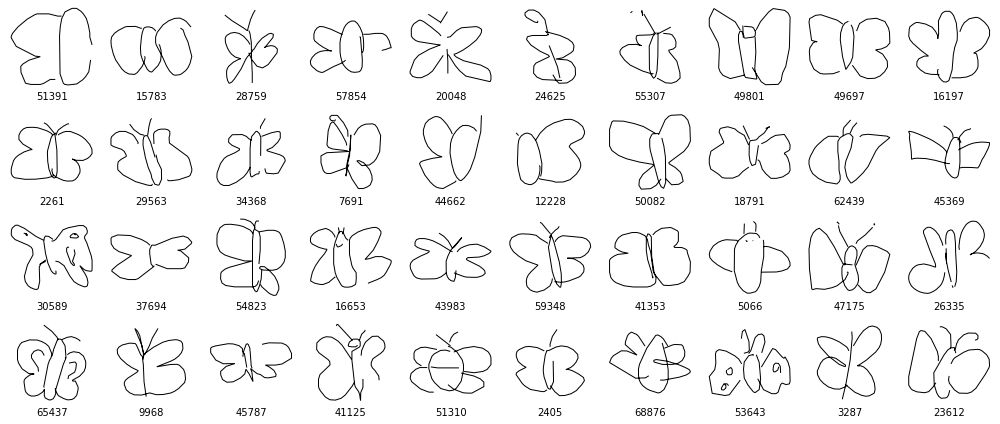

In [36]:
n = [4, 10]

fig, ax = plt.subplots(n[0],n[1],figsize=(14, 6))

perm = np.random.permutation(range(len(data_train)))[:n[0]*n[1]]

for i, idx in enumerate(perm):
    x, y = i // n[1], i % n[1]
    utils.plot_strokes(ax[x][y], data_train[idx])
    ax[x][y].set(xlabel=idx)
    
utils.plt_show()

In [37]:
hps = {
    "max_seq_len": max(map(len, np.concatenate([data['train'], data['valid'], data['test']]))),
    'batch_size': 100,
    "num_batches": math.ceil(len(data_train) / 100),
    "epochs": 100,
    "recurrent_dropout_prob": 0.0, ## 0.0 for gpu lstm
    "enc_rnn_size": 256,
    "dec_rnn_size": 512,
    "z_size": 128,
    "num_mixture": 20,
    "learning_rate": 0.001,
    "min_learning_rate": 0.00001,
    "decay_rate": 0.9999,
    "grad_clip": 1.0,
    'kl_tolerance': 0.2,
    'kl_decay_rate': 0.99995,
    "kl_weight": 0.5,
    'kl_weight_start': 0.01,
    'unconditional': False,
}

In [38]:
scale_factor = dataset.calc_scale_factor(data_train)

train_dataset = dataset.make_train_dataset(data_train, hps['max_seq_len'], hps['batch_size'], scale_factor)
val_dataset = dataset.make_val_dataset(data_valid, hps['max_seq_len'], hps['batch_size'], scale_factor)


In [39]:
sketchrnn = models.SketchRNN(hps)
sketchrnn.models['full'].summary()

Model: "sketchrnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 105, 6)]     0           []                               
                                                                                                  
 encoder (Functional)           [(None, 128),        669952      ['encoder_input[0][0]']          
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 decoder_input (InputLayer)     [(None, None, 6)]    0           []                               
                                                                                          

In [40]:
checkpoint_dir = '/content/gdrive/My Drive/DL Project/checkpoints'
log_dir = '/content/gdrive/My Drive/DL Project/logs'
# checkpoint_dir = '/'


!mkdir -p "{log_dir}" "{checkpoint_dir}"

initial_epoch =  0#@param {type: "number"}
initial_loss = 0.43 #@param {type: "number"}
checkpoint = os.path.join(checkpoint_dir, 'sketch_rnn_' + data_class + '_weights.{:02d}_{:.2f}.hdf5')

if initial_epoch > 0:
  sketchrnn.load_weights(checkpoint.format(initial_epoch, initial_loss))

In [ ]:
# Model is already trained. Uncomment to train another
# sketchrnn.train(initial_epoch, train_dataset, val_dataset, checkpoint)

In [41]:
qual_hps = {
    "max_seq_len": max(map(len, np.concatenate([data['train'], data['valid'], data['test']]))),
    'batch_size': 100,
    "num_batches": math.ceil(len(data_train) / 100),
    "epochs": 100,
    "recurrent_dropout_prob": 0.0, ## 0.0 for gpu lstm
    "enc_rnn_size": 256,
    "dec_rnn_size": 1024,
    "z_size": 128,
    "num_mixture": 20,
    "learning_rate": 0.001,
    "min_learning_rate": 0.00001,
    "decay_rate": 0.9999,
    "grad_clip": 1.0,
    'kl_tolerance': 0.2,
    'kl_decay_rate': 0.99995,
    "kl_weight": 0.5,
    'kl_weight_start': 0.01,
    'unconditional': False,
}

In [42]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from sklearn.preprocessing import minmax_scale
from IPython.display import clear_output
from matplotlib.path import Path
from matplotlib.patches import PathPatch

def make_mpl_path(strokes, square=False, offset=(0, 0), force_aspect=0):
    vertices = strokes[:, :-1].cumsum(axis=0, dtype=np.float32) * -1
    if len(vertices) > 0:
      if square:
        (minx, miny), (maxx, maxy) = vertices.min(0), vertices.max(0)
        aspect = (maxy - miny) / (maxx - minx)

        vertices = minmax_scale(vertices, (-1, 1), axis=0)

        if aspect < 1:
            vertices[:, 1] *= aspect
        else:
            vertices[:, 0] *= aspect
      vertices[:, 0] += offset[0]
      vertices[:, 1] += offset[1] 

        
      
    codes = np.roll(Path.LINETO - strokes[:, -1], 1).astype(int)
    return Path(vertices, codes)

def plot_strokes(ax, strokes, ec="black", no_ticks=True, offset=(0, 0)):
    patch = ax.add_patch(PathPatch(make_mpl_path(strokes, offset=offset), lw=1, ec=ec, fc="none"))
    if no_ticks:
        ax.set(xticks=[], yticks=[], frame_on=False)
    else:
        ax.set(frame_on=False)
    ax.axis("equal")
    return patch

In [49]:
# Predict the objects in the sentence and generate object and aspect ratio boxes for them
boxes, labels = predict(transformer, "butterfly next to bus")
mask = labels != 'no object'
objects = list(map(lambda x: x.split(".")[0], labels[mask]))
aspects = list(map(lambda x: abs(x[0]-x[2])/abs(x[1]-x[3]), boxes[mask]))
toplefts = list(map(lambda x: (x[1]*100, x[0]*100), boxes[mask]))
aspects = np.clip(aspects, 0.5, 1.5)
print(objects)
print(aspects)
print(toplefts)

['butterfly', 'bus']
[0.5       0.7800558]
[(41.89099967479706, 55.43198585510254), (40.55229127407074, 50.89452266693115)]


In [ ]:
obj1 = models.SketchRNN(hps)
obj2 = models.SketchRNN(hps)



obj1.load_weights("/content/drive/MyDrive/DL Project/trained_weights/sketch_rnn_bus_weights.100_-0.29.hdf5")
obj2.load_weights("/content/drive/MyDrive/DL Project/trained_weights/sketch_rnn_dog_weights.100_0.45.hdf5")

The code below generates scenes from our objects using the bounding boxes and aspect ratios provided by our scene composer

In [ ]:

n=(2, 2)
fig, ax = plt.subplots(n[0], n[1])

# Draw each object at its generated aspect ratio and offset
for i in range(n[0]*n[1]):
  strokes1 = obj1.sample(0.0000001, aspect=aspects[0])
  strokes2 = obj2.sample(0.000001, aspect=aspects[1])
  x, y = i // n[1], i % n[1]
  ax[x][y].set_xlim(0, 100)
  ax[x][y].set_ylim(0, 100)
  plot_strokes(ax[x][y], utils.to_normal_strokes(strokes1), offset=toplefts[0])
  plot_strokes(ax[x][y], utils.to_normal_strokes(strokes2), offset=toplefts[1])

utils.plt_show()

We need to generate model + human drawn image sets to measure our performance! The code below does that

In [ ]:
obj2 = models.SketchRNN(qual_hps)
obj2.load_weights("/content/drive/MyDrive/DL Project/trained_weights/sketch_rnn_butterfly_weights.18_0.11.hdf5")

n=(4, 5)
fig, ax = plt.subplots(n[0], n[1])
perm = np.random.permutation(range(len(data_train)))[:n[0]*n[1]]

# Draw each object at its generated aspect ratio and offset
for i in range(n[0]*n[1]):
  x, y = i // n[1], i % n[1]
  ax[x][y].set_xlim(0, 100)
  ax[x][y].set_ylim(0, 100)
  ax[x][y].set(xlabel=i)
  if i % 2 == 0:  
    strokes1 = obj2.sample(0.0001, aspect=1)
    plot_strokes(ax[x][y], utils.to_normal_strokes(strokes1), offset=toplefts[0])
  else:
    utils.plot_strokes(ax[x][y], data_train[perm[i]])
utils.plt_show()